 ST1510 PDAS CA2 Assignment Source File

 Name: Lee Hong Yi

 Admin Number: 2223010
 
 Class: DAAA/FT/1B/05

 ## Topic Question: How does humidity and temperature affect the amount of dengue cases?

 >Due to the nature at which the Dengue virus is transmitted, the actual goal of the analysis is not to see how temperature and humidity affect the spread of the disease, but instead finding out which temperatures and humidities are most conducive for the breeding of the Aedes mosquito.

>Using information gathered from research on the Aedes mosquito, it can be seen that a mosquito only becomes infective with the Dengue virus approximately 7 days after it has bitten a infected individual. Futhermore, as a newly hatched Aedes egg takes 6-7 days to grow into a adult, eggs laid by a Aedes mosquito will take 13-14 days to go from birth to being able to transmit the Dengue disease.

>Hence, the data for the dengue case count has to be delayed by 14 days, so that a accurate analysis on the most conducive weather for the breeding of the Aedes mosquito can be determined.

__In summary, the actual analysis is on which temperatures and humidities are the most conducive for the breeding of the Aedes mosquito in Singapore.__

In [85]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data files, initial cleaning and wrangling.

Importing data files for use, as well as selecting desired columns to analyze.

In [86]:
caseCount = pd.read_csv('./data/weekly-infectious-disease-bulletin-cases.csv')
station1weather = pd.read_csv('./data/angmokio.csv', dtype = {"Year":"str", "Month":"str", "Day":"str"})
station2weather = pd.read_csv('./data/changi.csv', dtype = {"Year":"str", "Month":"str", "Day":"str"})
station3weather = pd.read_csv('./data/tuassouth.csv', dtype = {"Year":"str", "Month":"str", "Day":"str"})

clean_station1weather = station1weather[["Station", "Year", "Month", "Day", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]]
clean_station2weather = station2weather[["Station", "Year", "Month", "Day", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]]
clean_station3weather = station3weather[["Station", "Year", "Month", "Day", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]]


Importing and cleanining humidity dataset, as well as renaming the columns to make them easier to refer to in future.

In [87]:
humidityData = pd.read_excel("./data/M890081.xlsx", header = 8)[0:11].transpose().set_index(0)
colNames = humidityData.head(1).transpose()
humidityData.columns =  colNames["Data Series"]
humidityData = humidityData[1:]
humidityDate = humidityData.index
humidityDate = pd.to_datetime(humidityDate, format = "%Y %b ")
humidityData["dateFixed"] = humidityDate
humidityData = humidityData.set_index("dateFixed")

humidityData = humidityData.rename(columns={"Air Temperature Means Daily Maximum (Degree Celsius)":"meanTempMax","Air Temperature Means Daily Minimum (Degree Celsius)":"meanTempMin","Air Temperature Absolute Extremes Maximum (Degree Celsius)":"extremeMeanTempMax","Air Temperature Absolute Extremes Minimum (Degree Celsius)":"extremeMeanTempMin","Total Rainfall (Millimetre)":"totalRainfall","Highest Daily Rainfall Total (Millimetre)":"peakDailyRainfall","Number Of Rainy Days (Number)":"noRainyDays","Bright Sunshine Daily Mean (Hour)":"hourOfSun","Minimum Relative Humidity (Per Cent)":"minHumidity","24 Hours Mean Relative Humidity (Per Cent)":"meanHumidityDaily"})
humidityData["meanTemp"] = (humidityData["meanTempMax"] + humidityData["meanTempMin"])/2
humidityData["averageRainfall"] = (humidityData["totalRainfall"]/ humidityData["noRainyDays"])
colOrder = ["meanTemp","averageRainfall","peakDailyRainfall", "meanHumidityDaily"]
clean_humidityData = humidityData[colOrder]

Cleaning weather datasets, as well as merging them with proper date strings.
In addition, the code below also creates a dataframe with data from all the weather stations.

In [88]:
dateDict = station1weather[["Year", "Month", "Day"]]
concatDates = dateDict["Year"].str.cat([dateDict["Month"], dateDict["Day"]], sep = "-")
dateDict.insert(3, "concatDate", concatDates)
pd.to_datetime(dateDict["concatDate"])

clean_station1weather = clean_station1weather.merge(dateDict, how = "inner")
clean_station2weather = clean_station2weather.merge(dateDict, how = "inner")
clean_station3weather = clean_station3weather.merge(dateDict, how = "inner")

colOrder = ["Station", "concatDate", "Daily Rainfall Total (mm)", "Mean Temperature (°C)"]
clean_station1weather = clean_station1weather[colOrder]
clean_station1weather = clean_station1weather.rename(columns = {"Daily Rainfall Total (mm)":"dailyRainfall", "Mean Temperature (°C)":"meanTemp"}).astype({"concatDate":"datetime64"})
clean_station2weather = clean_station2weather[colOrder]
clean_station2weather = clean_station2weather.rename(columns = {"Daily Rainfall Total (mm)":"dailyRainfall", "Mean Temperature (°C)":"meanTemp"}).astype({"concatDate":"datetime64"})
clean_station3weather = clean_station3weather[colOrder]
clean_station3weather = clean_station3weather.rename(columns = {"Daily Rainfall Total (mm)":"dailyRainfall", "Mean Temperature (°C)":"meanTemp"}).astype({"concatDate":"datetime64"})

clean_stationAllweather = pd.concat([clean_station1weather, clean_station2weather, clean_station3weather])

Merging all rainfall/temperature datasets so that they can be aggregated to obtain a approximate value for all of Singapore.

In [89]:
aggregratedRainfall = pd.DataFrame()
aggregratedRainfall["concatDate"] = pd.to_datetime(dateDict["concatDate"])
aggregratedRainfall = aggregratedRainfall.merge(clean_station1weather[["concatDate","dailyRainfall"]], how = "inner")
aggregratedRainfall = aggregratedRainfall.rename(columns = {"dailyRainfall":"angMoKio"})
aggregratedRainfall = aggregratedRainfall.merge(clean_station2weather[["concatDate","dailyRainfall"]], how = "inner")
aggregratedRainfall = aggregratedRainfall.rename(columns = {"dailyRainfall":"changi"})
aggregratedRainfall = aggregratedRainfall.merge(clean_station3weather[["concatDate","dailyRainfall"]], how = "inner")
aggregratedRainfall = aggregratedRainfall.rename(columns = {"dailyRainfall":"tuasSouth"})

aggregratedTemperature = pd.DataFrame()
aggregratedTemperature["concatDate"] = pd.to_datetime(dateDict['concatDate'])
aggregratedTemperature = aggregratedTemperature.merge(clean_station1weather[["concatDate","meanTemp"]], how = "inner")
aggregratedTemperature = aggregratedTemperature.rename(columns = {"meanTemp":"angMoKio"})
aggregratedTemperature = aggregratedTemperature.merge(clean_station2weather[["concatDate","meanTemp"]], how = "inner")
aggregratedTemperature = aggregratedTemperature.rename(columns = {"meanTemp":"changi"})
aggregratedTemperature = aggregratedTemperature.merge(clean_station3weather[["concatDate","meanTemp"]], how = "inner")
aggregratedTemperature = aggregratedTemperature.rename(columns = {"meanTemp":"tuasSouth"})

Averaging the datasets found in the earlier cells.

In [90]:
aggregratedRainfall["average"] = (aggregratedRainfall["angMoKio"] + aggregratedRainfall["changi"] + aggregratedRainfall["tuasSouth"])/3
aggregratedTemperature["average"] = (aggregratedTemperature["angMoKio"] + aggregratedTemperature["changi"] + aggregratedTemperature["tuasSouth"])/3
averageWeather = pd.DataFrame()
averageWeather["rainfall"] = aggregratedRainfall["average"]
averageWeather["temperature"] = aggregratedTemperature["average"]
averageWeather["fixedDate"] = aggregratedTemperature["concatDate"]

Cleaning the dengue dataset, especially regarding the date string provided, as well as seperating the desired data and placing it in it's own dataframe.
>As the number of cases for Dengue Haemorrhagic Fever are extremely low, the numbers will not have a large impact on the analysis of data, hence can be ignored.

In [91]:
with pd.option_context('mode.chained_assignment', None):
    caseCount["dateFixed"] = pd.to_datetime(caseCount["epi_week"] + "-0", format = '%G-W%V-%w')
    dengueCount = caseCount[caseCount['disease'] == "Dengue Fever"]
    dengueCount["delayedDate"] = dengueCount["dateFixed"] + pd.DateOffset(days = 14)
    dengueCount = dengueCount.set_index("dateFixed")
    dengueCount = dengueCount.rename(columns={"no._of_cases":"no_of_cases"})

Checking if there any missing values in any of the datasets.

In [92]:
print(f"Are there missing values in the humidityData dataset: {humidityData.isna().values.any()}")
print(f"Are there missing values in the clean_station1weather dataset: {clean_station1weather.isna().values.any()}")
print(f"Are there missing values in the clean_station2weather dataset: {clean_station2weather.isna().values.any()}")
print(f"Are there missing values in the clean_station3weather dataset: {clean_station3weather.isna().values.any()}")
print(f"Are there missing values in the averageWeather dataset: {averageWeather.isna().values.any()}")
print(f"Are there missing values in the dengueCount dataset: {dengueCount.isna().values.any()}")

Are there missing values in the humidityData dataset: False
Are there missing values in the clean_station1weather dataset: True
Are there missing values in the clean_station2weather dataset: False
Are there missing values in the clean_station3weather dataset: True
Are there missing values in the averageWeather dataset: True
Are there missing values in the dengueCount dataset: False


Dropping missing values from the dataset.
> Filling in the missing values via pandas or statsmodels is not applicable here, as the weather is unpredictable. In addition, since we are attempting to predicit individual values, and not attemmpting to determine a trend to fill in the missing values, it is thus better to drop the missing data instead.

In [93]:
clean_station1weather = clean_station1weather.dropna()
clean_station3weather = clean_station3weather.dropna()
averageWeather = averageWeather.dropna()

As the last dataset starts from 2014, data from before then in all datasets will be dropped and ignored.

In [94]:
clean_humidityData = clean_humidityData["2014-01-01":]
dengueCount = dengueCount["2014-01-01":]

Changing all values to a numeric datatype where needed.

In [95]:
clean_humidityData = clean_humidityData.astype(float)

Combining all datasets together for easier analysis.

In [96]:
combinedCaseTemp = pd.DataFrame()
combinedCaseTemp["dateFixed"] = pd.to_datetime(dateDict["concatDate"])
combinedCaseTemp = pd.merge(combinedCaseTemp, dengueCount[["no_of_cases","delayedDate"]], on = "dateFixed")
combinedCaseTemp = pd.merge(combinedCaseTemp, averageWeather, left_on = "dateFixed", right_on = "fixedDate")

combinedHumiTemp = pd.DataFrame()
combinedHumiTemp["dateFixed"] = pd.to_datetime(dateDict["concatDate"])
combinedHumiTemp = pd.merge(combinedHumiTemp, averageWeather, left_on = "dateFixed", right_on ="fixedDate")   
combinedHumiTemp = pd.merge(combinedHumiTemp, clean_humidityData, on ="dateFixed")   

combinedHumiCase = pd.DataFrame()
combinedHumiCase["dateFixed"]= pd.to_datetime(dateDict["concatDate"])
combinedHumiCase = pd.merge(combinedHumiCase,dengueCount[["no_of_cases","delayedDate"]], on ="dateFixed")
combinedHumiCase = pd.merge(combinedHumiCase, clean_humidityData, on = "dateFixed")

Resetting Seaborn style.

In [97]:
sns.set_style("darkgrid", {"grid.color":".6"})

# Plotting graphs for analysis

Plotting line graph of all dengue cases.

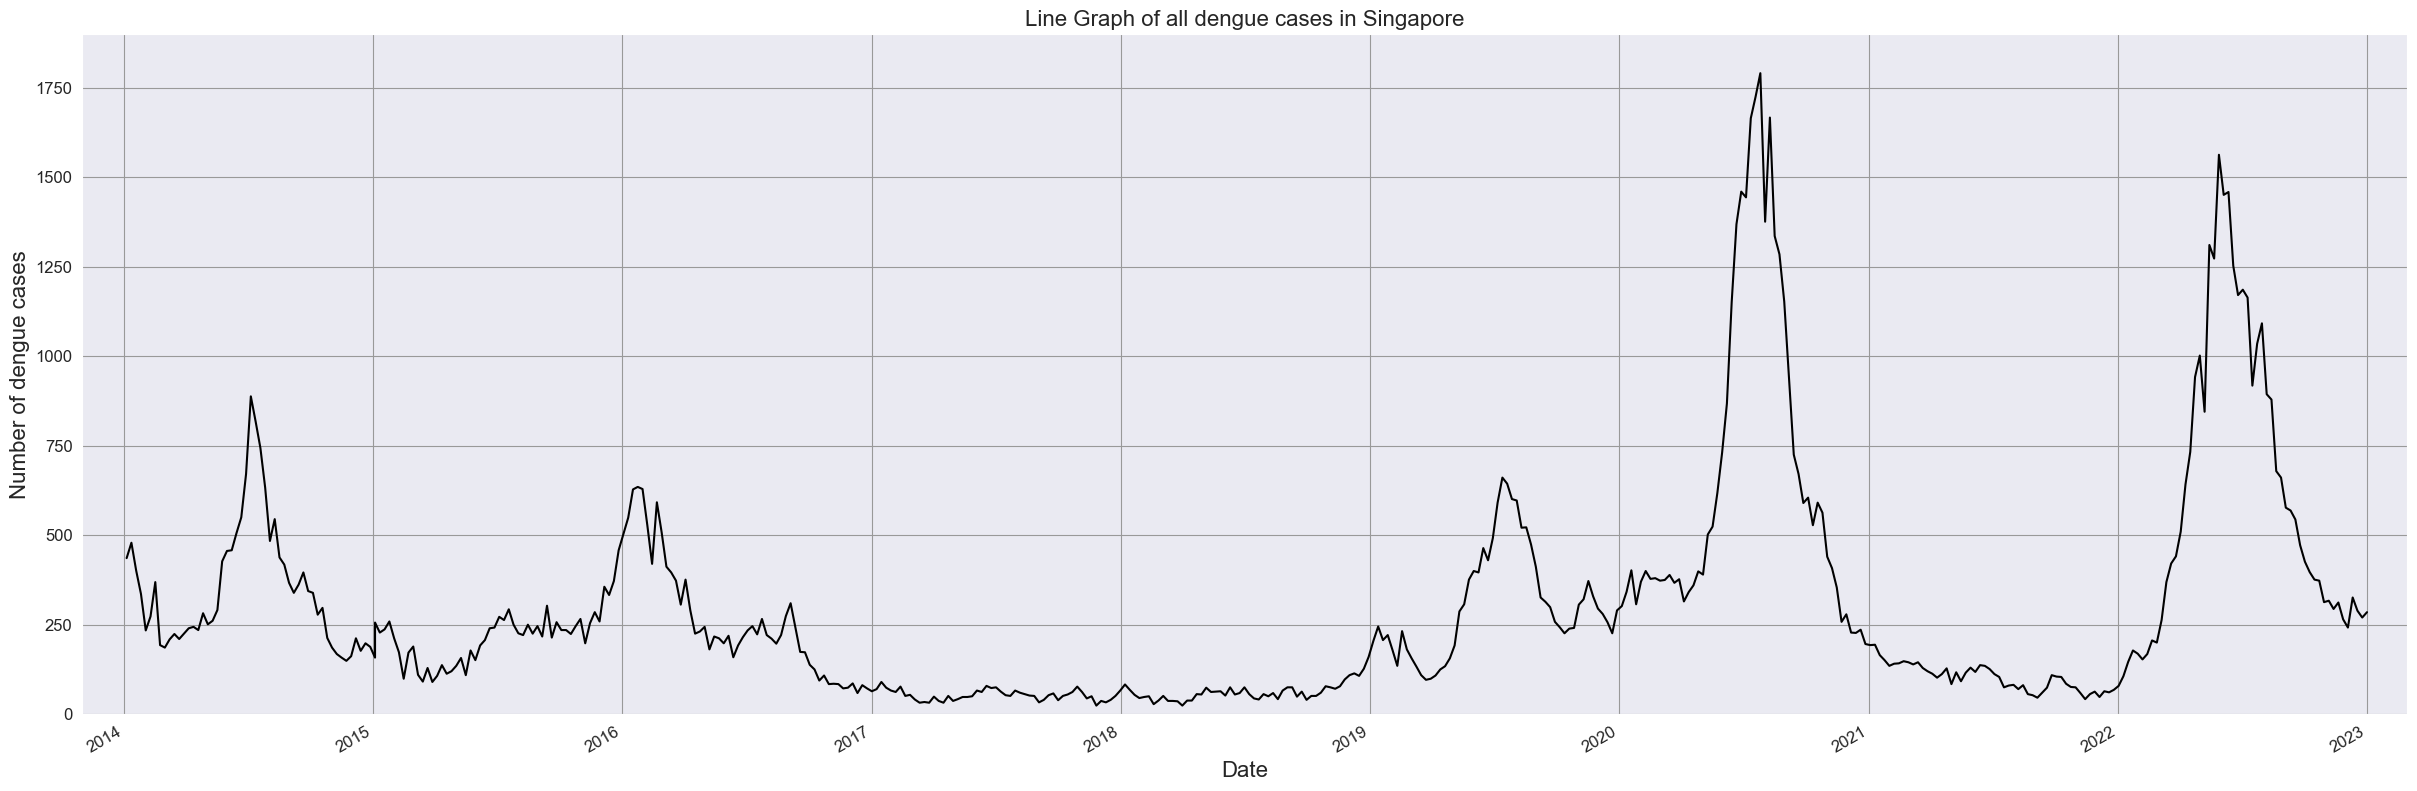

In [98]:
ax1 = dengueCount.plot(y = "no_of_cases", figsize = (30,10), fontsize = 12, color = "black", legend = False, use_index= True)
# plt.axvline(x = "2020-07-20", label = "1791 cases, during the week of 20 July 2020.", ymax = 0.94, color = "r")
# plt.axvline(x = "2022-05-23", label = "1563 cases, during the week of 06 June 2022.", ymax = 0.8226, color = "g")
ax1.margins(.05)
plt.axis(["2013-11-1", "2023-3-1", 0, 1900])
plt.ylabel("Number of dengue cases", fontdict={"size":16})
plt.xlabel("Date", fontdict={"size":16})
plt.title("Line Graph of all dengue cases in Singapore", fontdict={"size":16})

plt.show()

Plotting a regression model to visualize the relationship between rainfall and temperature.

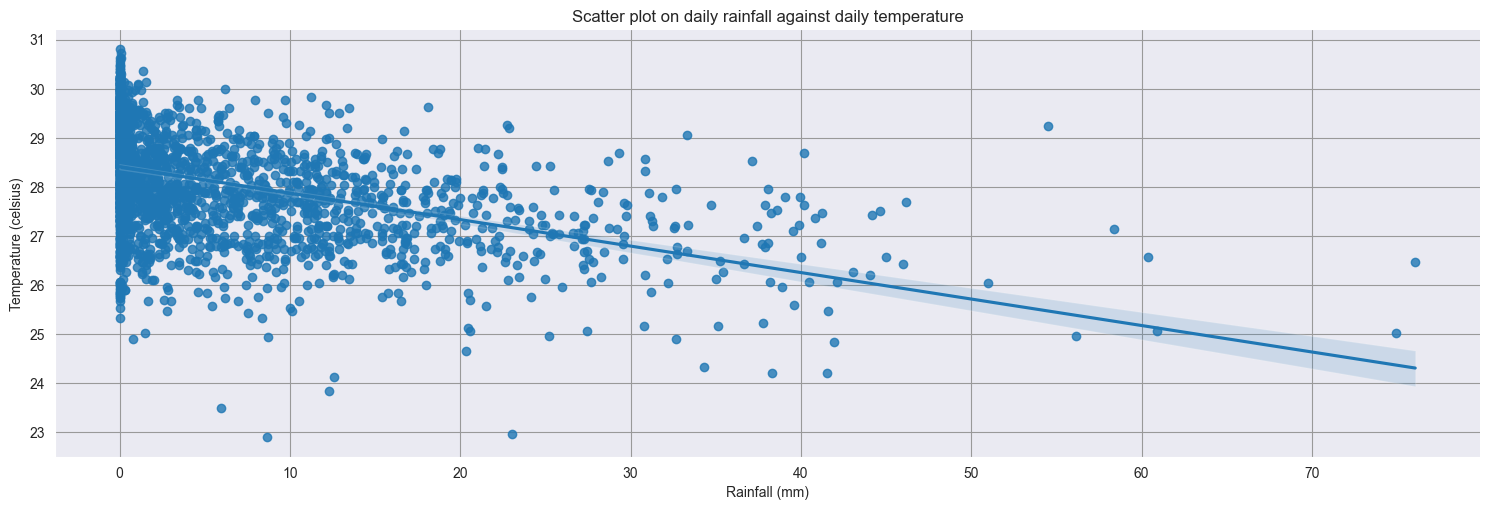

In [99]:
sns.lmplot(data = averageWeather, x = "rainfall",  y = "temperature", height = 5, aspect = 3)
plt.title("Scatter plot on daily rainfall against daily temperature")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Temperature (celsius)")
plt.show()

Visualizing the change in rainfall and humidity over the years.

Gradient of best-fit line: 0.006082864138252948
Gradient of best-fit line: 0.025485070801155193


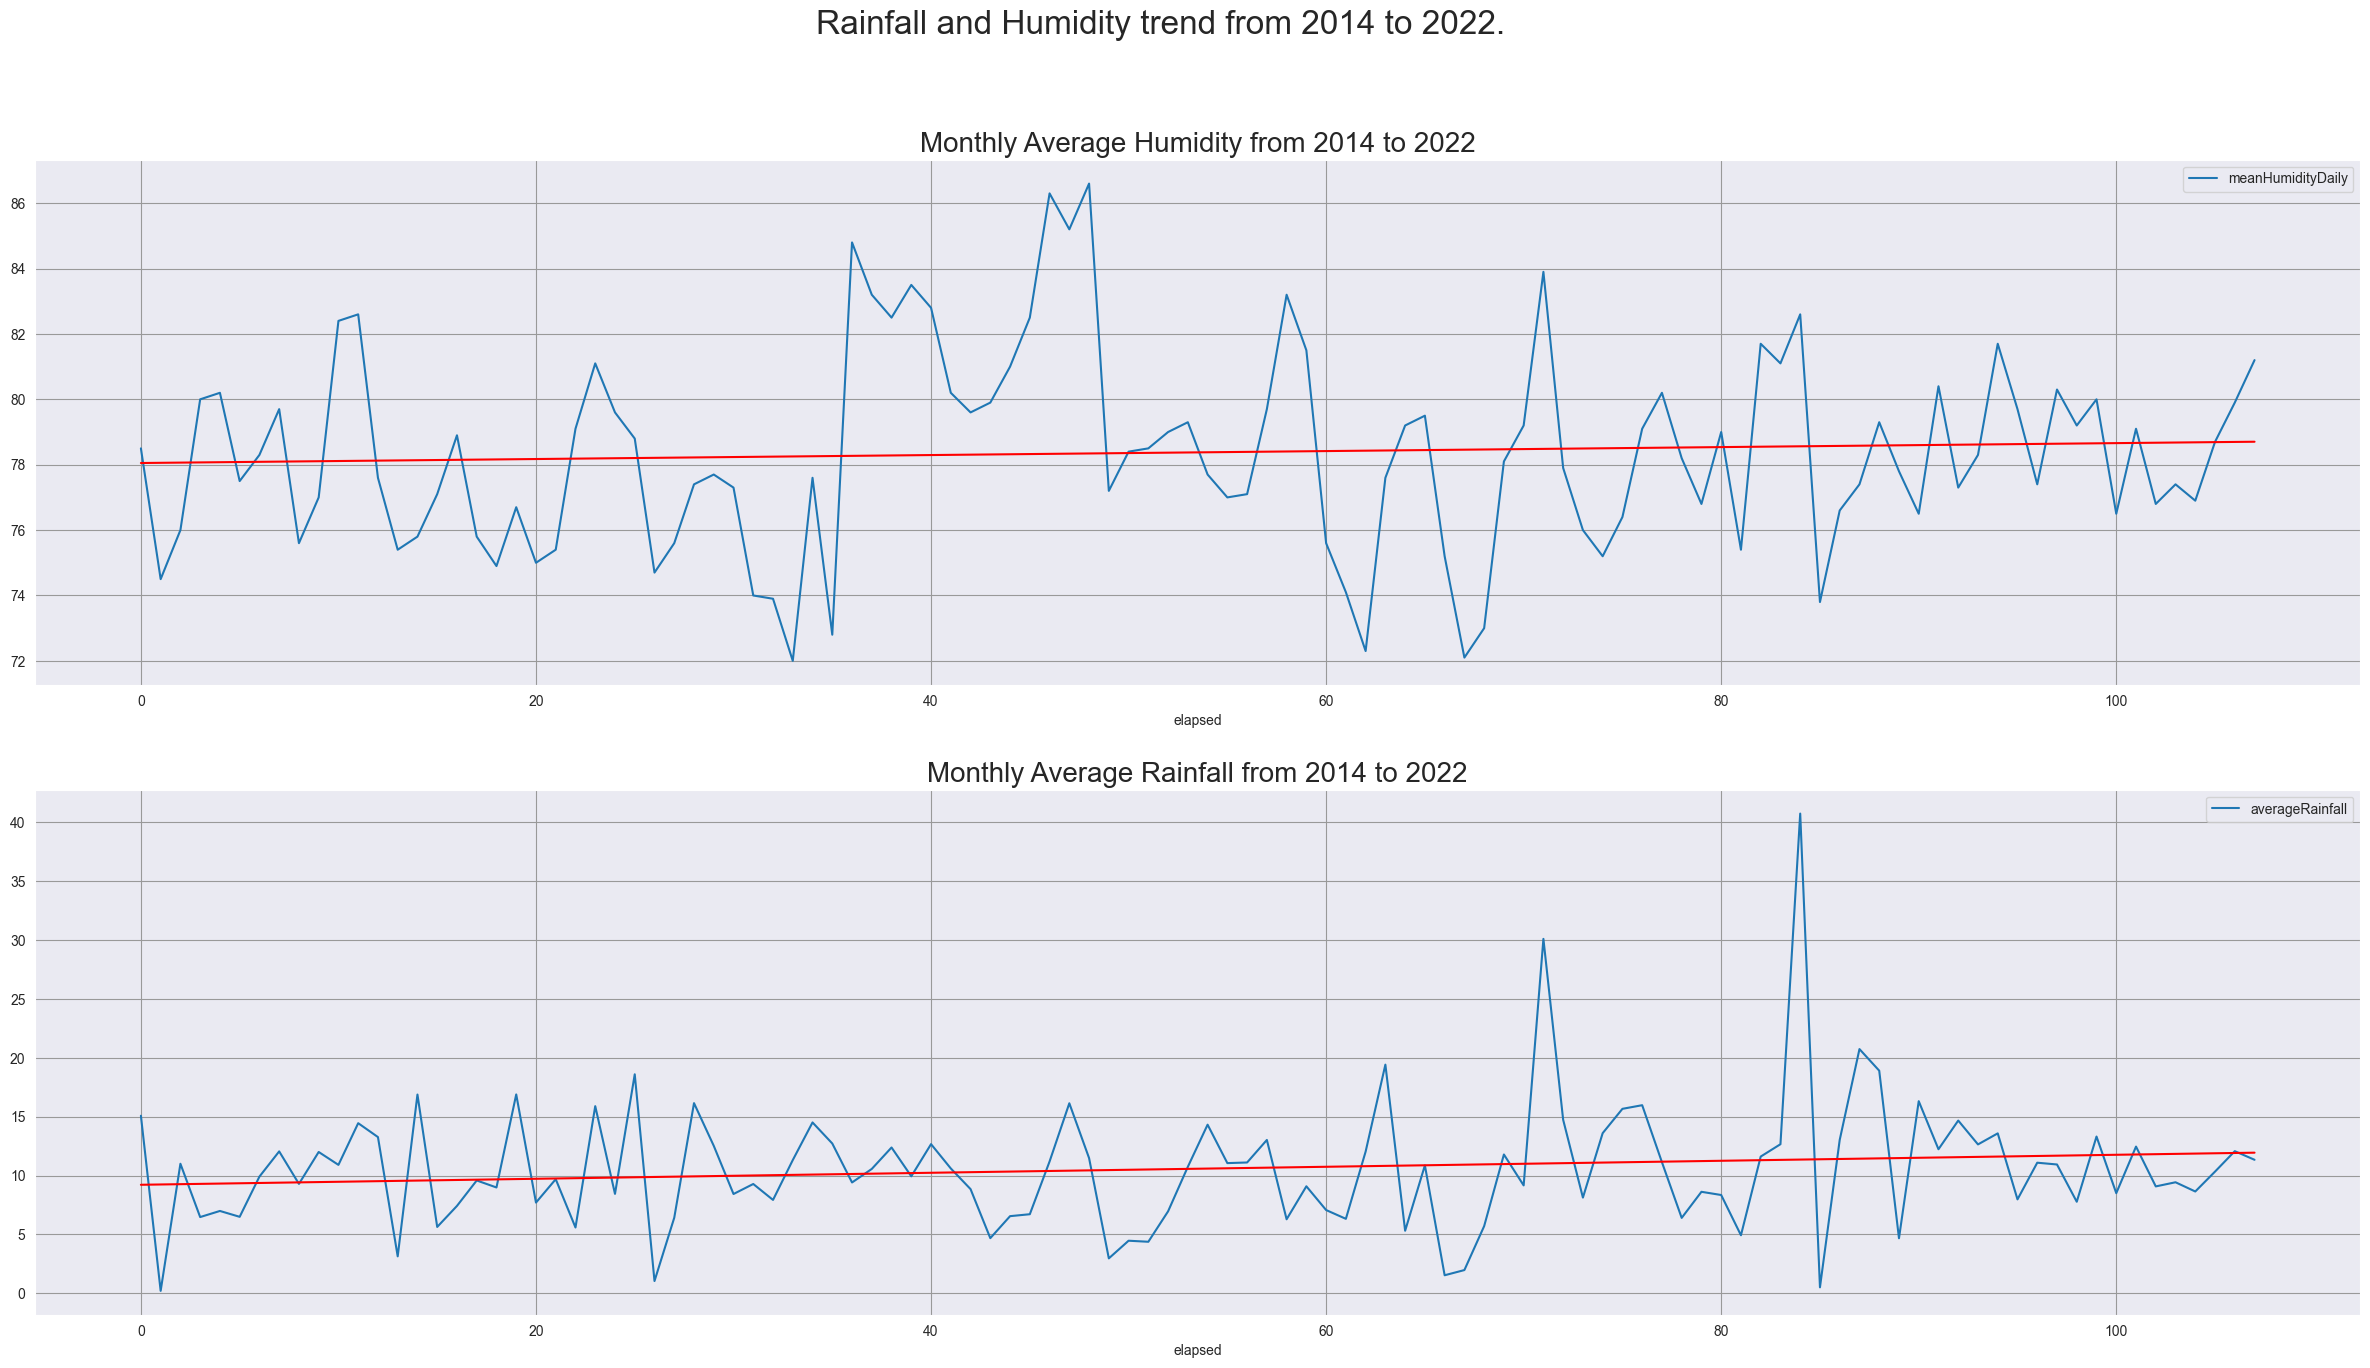

In [100]:
fig, ax = plt.subplots(2,1)
with pd.option_context('mode.chained_assignment', None):
    plt.suptitle("Rainfall and Humidity trend from 2014 to 2022.", fontsize = 24)
    plt.subplots_adjust(hspace = 0.2)

    clean_humidityData["elapsed"] = clean_humidityData.reset_index().index[::-1]
    clean_humidityData.plot(x = "elapsed", y = "meanHumidityDaily", figsize = (30,15), ax = ax[0])
    y = clean_humidityData["meanHumidityDaily"]
    y = pd.to_numeric(y)
    m,c = np.polyfit(clean_humidityData["elapsed"], y, deg = 1)
    print(f"Gradient of best-fit line: {m}")
    ax[0].plot(clean_humidityData["elapsed"], m*clean_humidityData["elapsed"]+c, color = "red")
    ax[0].set_title("Monthly Average Humidity from 2014 to 2022", fontsize = 20)


    clean_humidityData["elapsed"] = clean_humidityData.reset_index().index[::-1]
    clean_humidityData.plot(x = "elapsed", y = "averageRainfall", figsize = (30,15), ax = ax[1])
    y = clean_humidityData["averageRainfall"]
    y = pd.to_numeric(y)
    m,c = np.polyfit(clean_humidityData["elapsed"], y, deg = 1)
    print(f"Gradient of best-fit line: {m}")
    ax[1].plot(clean_humidityData["elapsed"], m*clean_humidityData["elapsed"]+c, color = "red")
    ax[1].set_title("Monthly Average Rainfall from 2014 to 2022", fontsize = 20)


plt.show()

Intercept      126.586341
temperature     -4.339661
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               rainfall   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     36.19
Date:                Thu, 02 Feb 2023   Prob (F-statistic):           5.47e-08
Time:                        16:47:55   Log-Likelihood:                -269.88
No. Observations:                  80   AIC:                             543.8
Df Residuals:                      78   BIC:                             548.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

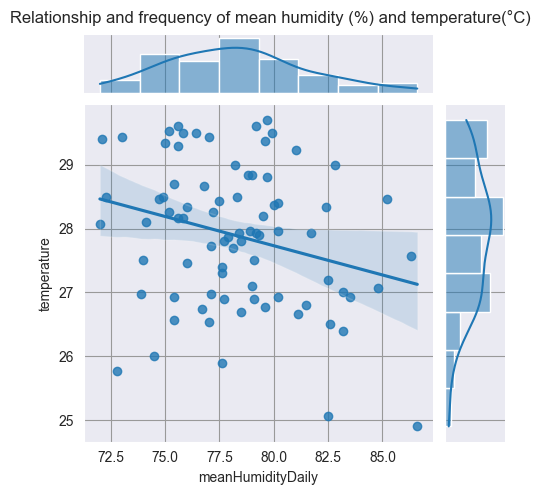

In [101]:
HumiTempModel = sm.OLS.from_formula("rainfall ~ temperature", data = combinedHumiTemp).fit()
print(HumiTempModel.params)
print(HumiTempModel.summary())
sns.jointplot(data = combinedHumiTemp, x = "meanHumidityDaily", y ="temperature", kind = "reg", height = 5)
plt.subplots_adjust(top = 0.93)
plt.suptitle('Relationship and frequency of mean humidity (%) and temperature(°C)')
plt.show()

Intercept     -566.109806
temperature     29.916832
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            no_of_cases   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.297
Date:                Thu, 02 Feb 2023   Prob (F-statistic):             0.0389
Time:                        16:47:56   Log-Likelihood:                -2414.9
No. Observations:                 341   AIC:                             4834.
Df Residuals:                     339   BIC:                             4841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

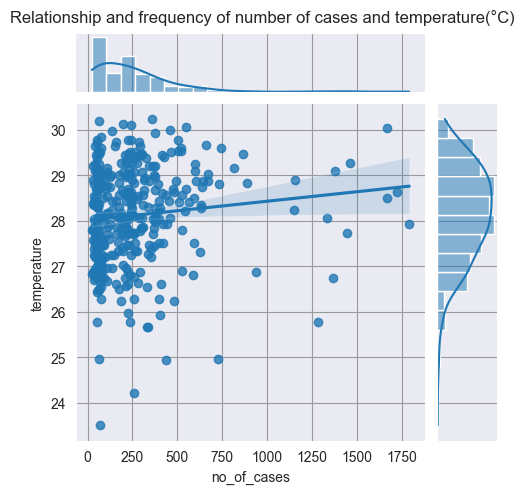

In [102]:
CaseTempModel = sm.OLS.from_formula("no_of_cases ~ temperature", data = combinedCaseTemp).fit()
print(CaseTempModel.params)
print(CaseTempModel.summary())
print(CaseTempModel.predict())
sns.jointplot(data = combinedCaseTemp, x = "no_of_cases", y ="temperature", kind = "reg", height = 5)
plt.subplots_adjust(top = 0.93)
plt.suptitle('Relationship and frequency of number of cases and temperature(°C)')
plt.show()

Intercept            1348.739295
meanHumidityDaily     -14.126759
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            no_of_cases   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.343
Date:                Thu, 02 Feb 2023   Prob (F-statistic):              0.271
Time:                        16:47:57   Log-Likelihood:                -82.695
No. Observations:                  13   AIC:                             169.4
Df Residuals:                      11   BIC:                             170.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

c:\Users\Hong Yi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


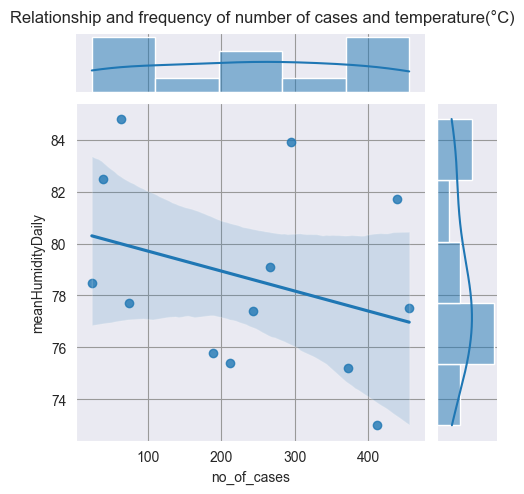

In [103]:
HumiCaseModel = sm.OLS.from_formula("no_of_cases ~ meanHumidityDaily", data = combinedHumiCase).fit()
print(HumiCaseModel.params)
print(HumiCaseModel.summary())
sns.jointplot(data = combinedHumiCase, x = "no_of_cases", y ="meanHumidityDaily", kind = "reg", height = 5)
plt.subplots_adjust(top = 0.93)
plt.suptitle('Relationship and frequency of number of cases and temperature(°C)')
plt.show()